<a href="https://colab.research.google.com/github/IsaacFigNewton/Smishing-Detector/blob/sklearn-approach/Smishing_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

<ol>
  <li>Reimplement the TF-IDF scoring system; Score = (token TF-IDF scores from ham) - (token TF-IDF scores from spam).</li>
  <li>Use regexes to parse, score, then replace emails, phone numbers, and URLs with a dummy string for later NLP.</li>
  <li>Handle common symbol replacements and letter substitutions.</li>
  <li>Use stemming and lemmatization to reduce the TFIDF token vector space.</li>
</ol>

# Import and config

## Install packages

### Autocorrecters

In [1]:
# can't seem to get this to work, keep getting UnpicklingError: invalid load key, '<'. when loading pretrained model
# !pip install neuspell

In [2]:
# import neuspell
# # Sample text to correct
# sample_text = "Iate taht appl"
# print(sample_text)
# print()

# # BERT correction
# def bert_correct(text):
#     checker = neuspell.BertChecker()
#     checker.from_pretrained()
#     return checker.correct(text)

# bert_corrected = bert_correct(sample_text)

# print(f"BERT corrected: {bert_corrected}")

In [3]:
# https://github.com/filyp/autocorrect
!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=8f179e4e4af50481cb02d021c6a6fc9a92b6baecbbc2da1e983a1e3123e68567
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [4]:
#https://github.com/keredson/wordninja
!pip install wordninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=efc5e9146a96de6e1fae506422f44bd6f96c65663f383d0727de66b98c07a875
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


### Text Embedders

In [5]:
# https://sbert.net/
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [6]:
# https://github.com/MaartenGr/BERTopic
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


## Import Libraries

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse
import re

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.metrics.pairwise import cosine_similarity,\
                                     cosine_distances

from sklearn.cluster import KMeans,\
                            SpectralClustering
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier,\
                            KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,\
                            DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,\
                            VotingClassifier,\
                            VotingRegressor,\
                            StackingRegressor
from sklearn.neural_network import MLPClassifier,\
                            MLPRegressor
from sklearn.model_selection import train_test_split,\
                            cross_val_score,\
                            GridSearchCV


import seaborn as sns

In [8]:
import nltk
# nltk.download('punkt')
# from nltk.tokenize import punkt
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
# Text preprocessing

import wordninja
from autocorrect import Speller

In [10]:
# Vectorizers

# TF-IDF
from sklearn.feature_extraction.text import CountVectorizer,\
                                            TfidfVectorizer

# Use BERT as the sentence encoder since it's the best open-source option
from sentence_transformers import SentenceTransformer

# use the bertopic text class vectorizer
from bertopic import BERTopic

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Set global variables

In [11]:
class_map = {"ham": 0, "spam": 1}
color_map = {0: "green", 1: "red"}

char_ngrams = (1, 6)
word_ngrams = (1, 3)
minSusLen = 500
lenWeight = 0.01

np.random.seed(10)
random_state = 0

## Create NLP preprocessors

In [12]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [13]:
# Regex for phone numbers
phone_regex = re.compile(r'(\+\d{1,2}\s?)?\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}')

# Regex for emails
email_regex = re.compile(r'[A-Za-z0-9. _%-]+@[A-Za-z0-9. -]+\\. [A-Za-z]{2,4}')

# Regex for URLs
url_regex = re.compile(r'https?:\/\/(www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,6}(/[a-zA-Z0-9._~:/?#[\]@!$&\'()*+,;=-]*)?')

In [14]:
speller = Speller(lang="en")

## Create Embedding Models

In [15]:
def get_ngrams(document, word_ngram_range=(1, 3), char_ngram_range=(1, 3)):
    # Get word n-grams
    word_vectorizer = CountVectorizer(ngram_range=word_ngram_range, analyzer='word')
    word_analyzer = word_vectorizer.build_analyzer()
    word_ngrams = word_analyzer(document)

    # Get character n-grams
    char_vectorizer = CountVectorizer(ngram_range=char_ngram_range, analyzer='char')
    char_analyzer = char_vectorizer.build_analyzer()
    char_ngrams = char_analyzer(document)

    return char_ngrams + word_ngrams

In [16]:
# Load a pretrained Sentence Transformer model
# https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html#language
topic_model = BERTopic(top_n_words=15,\
                       n_gram_range=word_ngrams,\
                       min_topic_size=10,\
                       nr_topics=50,\
                       calculate_probabilities=True)

# Load a pretrained Sentence Transformer model
sentence_embedder = SentenceTransformer("all-MiniLM-L6-v2")

# create the vectorizer
vec = TfidfVectorizer(\
                      analyzer=get_ngrams,\
                      ngram_range=word_ngrams,\
                      norm="l2",\
                      min_df=0.001,\
                      max_df=0.9,\
                      sublinear_tf=False)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#Import and clean data

##Important Functions

In [17]:
def get_contact_counts(doc):
    # Find phone numbers
    phones = phone_regex.findall(doc)

    # Find emails
    emails = email_regex.findall(doc)

    # Find URLs
    urls = url_regex.findall(doc)

    return (len(phones), len(emails), len(urls))

In [18]:
def leet_to_english(text):
    leet_dict = {
        '0': 'o',
        '1': 'l',
        '3': 'e',
        '4': 'a',
        '5': 's',
        '7': 't',
        '8': 'b',
        '9': 'g'
    }

    # Add common leet transformations if needed
    for leet, eng in leet_dict.items():
        text = text.replace(leet, eng)

    return text

## Import, Prepare data

In [19]:
corpus = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Smishing-Detector/sklearn-approach/dataset/SMSSpamCollection.txt", sep="\t", on_bad_lines='warn')

# clean the corpus
corpus = corpus.dropna(axis=0)

# rename dataset columns
corpus.columns = ["class", "text"]

# save data info for later exploration
corpus_counts = corpus["class"].value_counts()

# convert the class to a numeric value
corpus["class"] = corpus["class"].map(class_map)

# get a subset of the dataset for model testing before training on whole dataset
corpus = corpus.loc[:1000]

In [20]:
print(corpus_counts)

class
ham     4824
spam     747
Name: count, dtype: int64


## Clean Data and Extract Features

In [21]:
# extract numerical features

# count number of integers
corpus["num_digits"] = corpus["text"].apply(lambda s: sum(word.isdigit() for word in s.split()))

# get the number of contacts in the sms
# corpus["phone_count", "email_count", "url_count"] = corpus["text"].apply(lambda x: get_contact_counts(x))
contact_counts = corpus["text"].apply(lambda x: get_contact_counts(x))
corpus["phone_count"] = contact_counts.apply(lambda x: x[0])
corpus["email_count"] = contact_counts.apply(lambda x: x[1])
corpus["url_count"] = contact_counts.apply(lambda x: x[2])

In [22]:
# extract character features

# get the number of characters in the sms
corpus["char_count"] = corpus["text"].apply(lambda x: len(x))

# get the number of unique characters in the sms
corpus["unique_char_count"] = corpus["text"].apply(lambda x: len(set(x)))

In [23]:
# remove numerical features from base text

# remove contact info from text, replacing it with filler
corpus["text_with_replacements"] = corpus["text"].apply(lambda x: re.sub(phone_regex, "phone", x))
corpus["text_with_replacements"] = corpus["text"].apply(lambda x: re.sub(email_regex, "email", x))
corpus["text_with_replacements"] = corpus["text"].apply(lambda x: re.sub(url_regex, "url", x))

# fix common leet replacements
# corpus["text_with_replacements"] = corpus["text"].apply(lambda x: leet_to_english(x))

In [24]:
test_str = "Iate taht appl"
print("Test string: " + test_str)
print()

split_str = " ".join(wordninja.split(test_str))
corrected_str = speller(test_str)
print("Split string: " + split_str)
print("Corrected string: " + corrected_str)
print()
print("Split Corrected string: " + " ".join(wordninja.split(corrected_str)))
print("Corrected Split string: " + speller(split_str))

Test string: Iate taht appl

Split string: I ate tah t a ppl
Corrected string: Date that apply

Split Corrected string: Date that apply
Corrected Split string: I ate tah t a ppl


In [25]:
# # probabilistically break up any words with missing spaces
# corpus["text_with_replacements"] = corpus["text_with_replacements"].apply(lambda x: " ".join(wordninja.split(x)))

# # correct spelling for better embedding
# corpus["text_with_replacements"] = corpus["text_with_replacements"].apply(lambda x: speller(x))

# remove stop words and lemmatize text
# corpus["text_with_replacements"] = corpus["text_with_replacements"]\
#                                       .apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))

In [26]:
# extract word features

# get the number of words in the sms
corpus["word_count"] = corpus["text_with_replacements"].apply(lambda x: len(x.split()))

# get the number of unique words in the sms
corpus["unique_word_count"] = corpus["text_with_replacements"].apply(lambda x: len(set(x.split())))

In [27]:
print(corpus.columns)

Index(['class', 'text', 'num_digits', 'phone_count', 'email_count',
       'url_count', 'char_count', 'unique_char_count',
       'text_with_replacements', 'word_count', 'unique_word_count'],
      dtype='object')


In [28]:
scaler = Normalizer()
cols_to_normalize = ["word_count", "char_count", "unique_word_count", "unique_char_count", "num_digits", "phone_count", "email_count", "url_count"]
scaled_cols_to_normalize = ["scaled_" + col for col in cols_to_normalize]

# Normalize value count columns
corpus[scaled_cols_to_normalize] = scaler.fit_transform(corpus[cols_to_normalize].values)

In [29]:
# get training, test data
train, test = train_test_split(corpus, test_size=0.2)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [30]:
train.head()

,class,text,num_digits,phone_count,email_count,url_count,char_count,unique_char_count,text_with_replacements,word_count,unique_word_count,scaled_word_count,scaled_char_count,scaled_unique_word_count,scaled_unique_char_count,scaled_num_digits,scaled_phone_count,scaled_email_count,scaled_url_count
0,0,How are you doing? Hope you've settled in for ...,0,0,0,0,92,26,How are you doing? Hope you've settled in for ...,19,18,0.191685,0.928157,0.181596,0.262305,0.000000,0.0,0.0,0.0
1,0,Would really appreciate if you call me. Just n...,0,0,0,0,69,21,Would really appreciate if you call me. Just n...,13,13,0.174658,0.927031,0.174658,0.282140,0.000000,0.0,0.0,0.0
2,0,I like to talk pa but am not able to. I dont k...,0,0,0,0,52,18,I like to talk pa but am not able to. I dont k...,14,13,0.240346,0.892712,0.223178,0.309016,0.000000,0.0,0.0,0.0
3,0,7 at esplanade.. Do ü mind giving me a lift co...,1,0,0,0,68,22,7 at esplanade.. Do ü mind giving me a lift co...,16,16,0.213409,0.906989,0.213409,0.293438,0.013338,0.0,0.0,0.0
4,0,U don't remember that old commercial?,0,0,0,0,37,17,U don't remember that old commercial?,6,6,0.144254,0.889567,0.144254,0.408720,0.000000,0.0,0.0,0.0


In [31]:
test.head()

,class,text,num_digits,phone_count,email_count,url_count,char_count,unique_char_count,text_with_replacements,word_count,unique_word_count,scaled_word_count,scaled_char_count,scaled_unique_word_count,scaled_unique_char_count,scaled_num_digits,scaled_phone_count,scaled_email_count,scaled_url_count
0,0,Our Prashanthettan's mother passed away last n...,0,0,0,0,76,23,Our Prashanthettan's mother passed away last n...,12,12,0.147788,0.935992,0.147788,0.283261,0.000000,0.0,0.0,0.0
1,0,Your brother is a genius,0,0,0,0,24,14,Your brother is a genius,5,5,0.174395,0.837096,0.174395,0.488306,0.000000,0.0,0.0,0.0
2,0,"Yar lor he wan 2 go c horse racing today mah, ...",1,0,0,0,88,25,"Yar lor he wan 2 go c horse racing today mah, ...",20,20,0.208855,0.918963,0.208855,0.261069,0.010443,0.0,0.0,0.0
3,0,"Bloody hell, cant believe you forgot my surnam...",0,0,0,0,105,27,"Bloody hell, cant believe you forgot my surnam...",21,21,0.186816,0.934081,0.186816,0.240192,0.000000,0.0,0.0,0.0
4,0,No we sell it all so we'll have tons if coins....,0,0,0,0,126,30,No we sell it all so we'll have tons if coins....,25,24,0.186458,0.939749,0.179000,0.223750,0.000000,0.0,0.0,0.0


# Data Exploration

## Important Functions

In [32]:
def plot_freqs(col, xlabel, ylabel, title):
  plt.figure(figsize=(15, 5))
  plt.hist(corpus[corpus['class']==0][col],\
          bins=50,\
          label='Ham',\
          alpha=0.5)
  plt.hist(corpus[corpus['class']==1][col],\
          bins=50,\
          label='Spam',\
          alpha=0.5)
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

## Plots, Charts, Diagrams

<Axes: xlabel='class'>

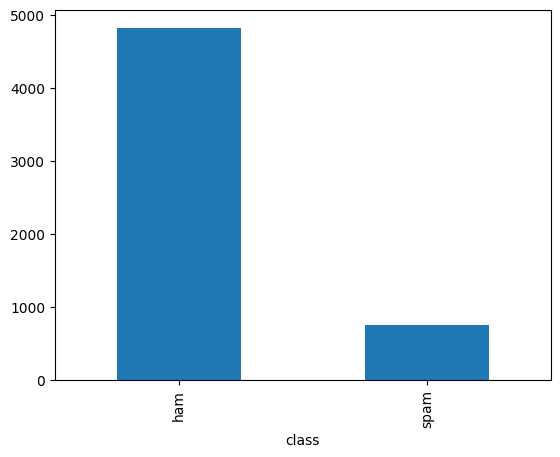

In [33]:
corpus_counts.plot.bar()

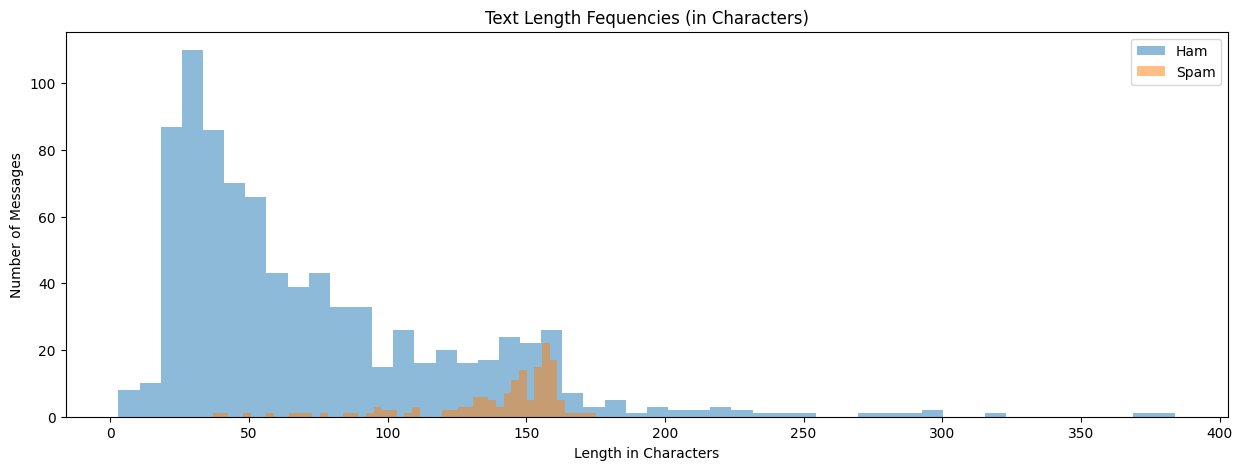

In [34]:
# frequency plot of lengths in characters
plot_freqs("char_count", 'Length in Characters', 'Number of Messages', "Text Length Fequencies (in Characters)")

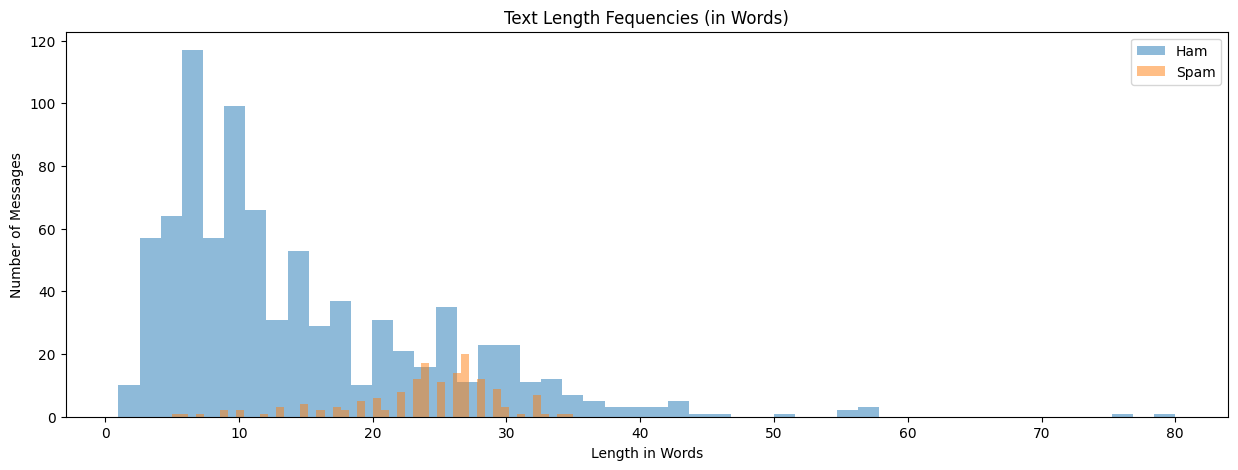

In [35]:
# frequency plot of lengths
plot_freqs("word_count", 'Length in Words', 'Number of Messages', "Text Length Fequencies (in Words)")

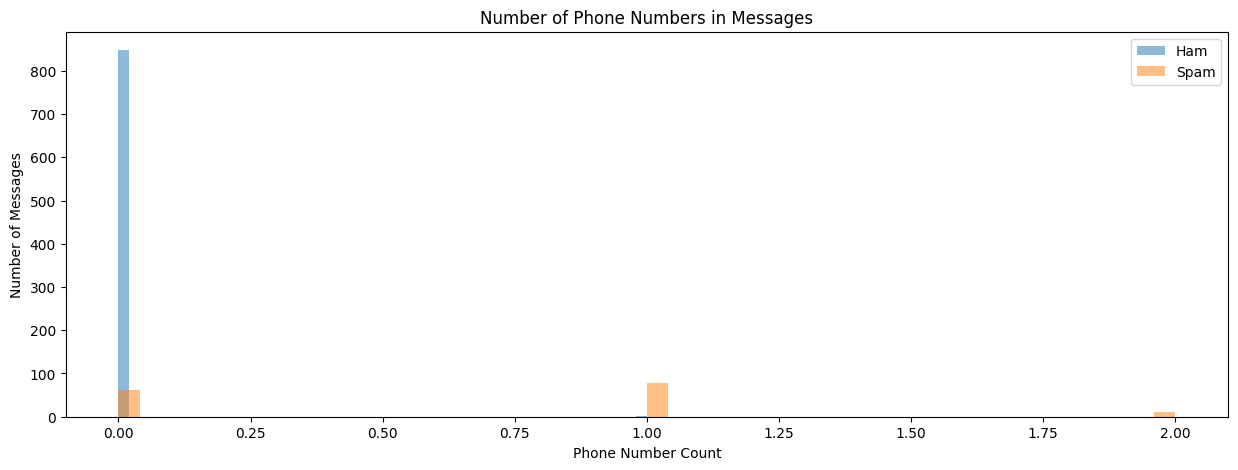

In [36]:
# frequency plot of lengths
plot_freqs("phone_count", "Phone Number Count", 'Number of Messages', "Number of Phone Numbers in Messages")

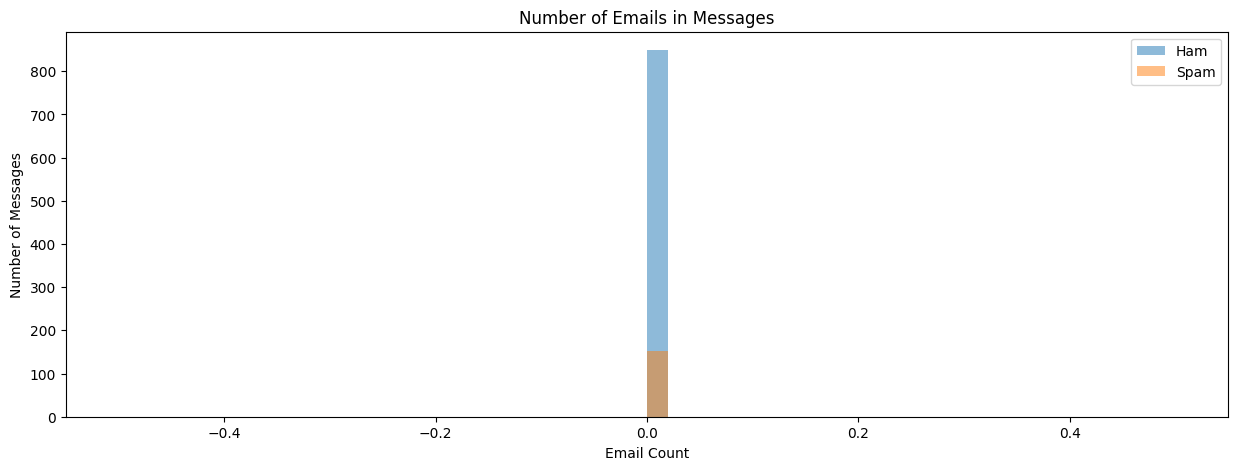

In [37]:
# frequency plot of lengths
plot_freqs("email_count", "Email Count", 'Number of Messages', "Number of Emails in Messages")

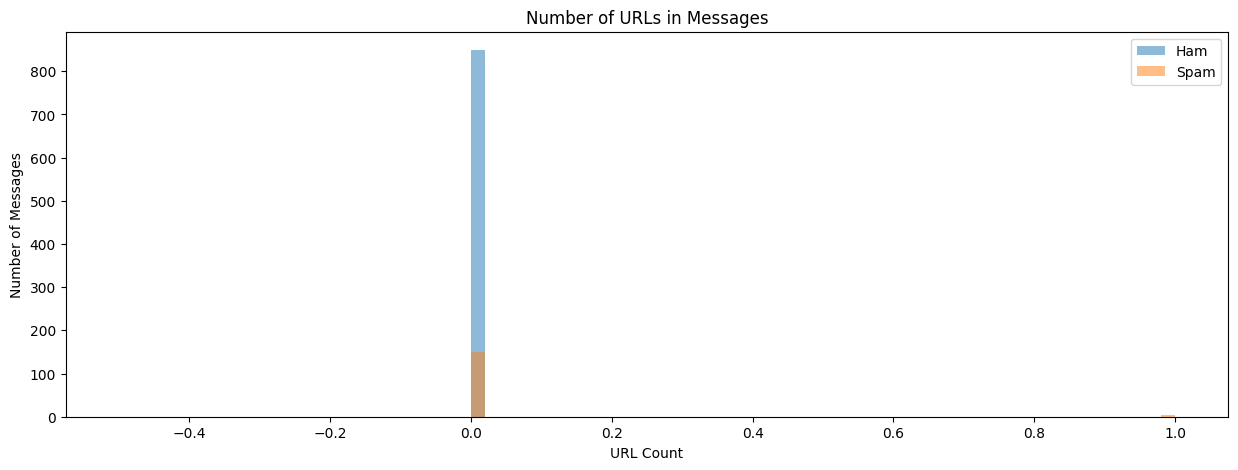

In [38]:
# frequency plot of lengths
plot_freqs("url_count", "URL Count", 'Number of Messages', "Number of URLs in Messages")

# Embed the text in vector spaces

## Vectorize Corpus

In [39]:
# TF-IDF vectorizer
vec.fit(corpus["text_with_replacements"])
train_vects = vec.transform(train["text_with_replacements"])
test_vects = vec.transform(test["text_with_replacements"])
corpus_tfidf_vects = vec.transform(corpus["text_with_replacements"])

# BERTopic topic vectorizer
train_topics, train_probs = topic_model.fit_transform(train["text_with_replacements"])
test_topics, test_probs = topic_model.fit_transform(test["text_with_replacements"])
bertopic_topics, bertopic_probs = topic_model.fit_transform(corpus["text_with_replacements"])

# BERT sentence embedder
train_embeddings = sentence_embedder.encode(train["text_with_replacements"])
test_embeddings = sentence_embedder.encode(test["text_with_replacements"])
bert_embeddings = sentence_embedder.encode(corpus["text_with_replacements"])

In [40]:
vec.vocabulary_

{'k': 4485,
 'l': 4613,
 'r': 6299,
 '.': 627,
 'j': 4432,
 'g': 3584,
 'w': 8037,
 'f': 3359,
 'u': 7700,
 'ok': 5746,
 'k ': 4486,
 ' l': 251,
 'la': 4666,
 'ar': 1986,
 'r.': 6342,
 '..': 666,
 '. ': 628,
 ' j': 236,
 'jo': 4449,
 'ki': 4564,
 'in': 4251,
 'ng': 5442,
 'g ': 3585,
 ' w': 381,
 'wi': 8258,
 'if': 4183,
 'f ': 3360,
 ' u': 360,
 'u ': 7701,
 ' o': 281,
 'on': 5789,
 'ni': 5457,
 'i.': 4130,
 'ok ': 5747,
 'k l': 4499,
 ' la': 253,
 'lar': 4689,
 'ar.': 1989,
 'r..': 6344,
 '...': 670,
 '.. ': 667,
 '. j': 646,
 ' jo': 240,
 'jok': 4457,
 'oki': 5760,
 'kin': 4570,
 'ing': 4300,
 'ng ': 5443,
 'g w': 3610,
 ' wi': 385,
 'wif': 8261,
 'if ': 4184,
 'f u': 3380,
 ' u ': 361,
 'u o': 7721,
 ' on': 288,
 'oni': 5823,
 'i..': 4132,
 'joking': 4459,
 'ok lar': 5751,
 'y': 8431,
 '2': 1050,
 'c': 2366,
 'm': 4956,
 'p': 6017,
 's': 6638,
 '1': 927,
 '0': 780,
 '5': 1290,
 'x': 8372,
 '8': 1454,
 '7': 1400,
 'v': 7953,
 'q': 6279,
 '(': 506,
 'd': 2748,
 ')': 514,
 '&': 459,
 

## Get topic assignments

In [41]:
# Function to extract the number from the topic string
def extract_number(topic):
    return int(topic.split()[1])

In [42]:
train_topics_probs_df = pd.DataFrame(data = train_probs,\
                            columns=["Topic " + str(i) + " Probability" for i in range(len(set(train_topics)) - 1)]\
)

test_topics_probs_df = pd.DataFrame(data = test_probs,\
                            columns=["Topic " + str(i) + " Probability" for i in range(len(set(test_topics)) - 1)]\
)

bertopic_topics_probs_df = pd.DataFrame(data = bertopic_probs,\
                            columns=["Topic " + str(i) + " Probability" for i in range(len(set(bertopic_topics)) - 1)]\
)

# Ensure only numeric columns are used for finding max values and their indices
numeric_train = train_topics_probs_df.select_dtypes(include=[float, int])
numeric_test = test_topics_probs_df.select_dtypes(include=[float, int])
numeric_bertopic = bertopic_topics_probs_df.select_dtypes(include=[float, int])

# Get the assigned topic, which may not exist, in which case it will be -1
train_topics_probs_df["Assigned Topic"] = pd.Series(train_topics)
# Get the topic with the highest probability for each row
train_topics_probs_df["Predicted Topic"] = numeric_train\
                                          .idxmax(axis=1, skipna=True)\
                                          .apply(extract_number)
# Get the assigned topic, which may not exist, in which case it will be -1
test_topics_probs_df["Assigned Topic"] = pd.Series(test_topics)
# Get the topic with the highest probability for each row
test_topics_probs_df["Predicted Topic"] = numeric_test\
                                          .idxmax(axis=1, skipna=True)\
                                          .apply(extract_number)

bertopic_topics_probs_df["Assigned Topic"] = pd.Series(bertopic_topics)
# Get the topic with the highest probability for each row
bertopic_topics_probs_df["Predicted Topic"] = numeric_bertopic\
                                          .idxmax(axis=1, skipna=True)\
                                          .apply(extract_number)

# Get the associated max probability of topic association for each row
train_topics_probs_df["Predicted Topic Probability"] = numeric_train.max(axis=1, skipna=True)
test_topics_probs_df["Predicted Topic Probability"] = numeric_test.max(axis=1, skipna=True)

bertopic_topics_probs_df["Predicted Topic Probability"] = numeric_bertopic.max(axis=1, skipna=True)

# print(test_topics_probs_df.dtypes)
test_topics_probs_df.head()

,Topic 0 Probability,Topic 1 Probability,Topic 2 Probability,Topic 3 Probability,Assigned Topic,Predicted Topic,Predicted Topic Probability
0,0.669679,0.099742,0.078632,0.077427,-1,0,0.669679
1,0.327057,0.216595,0.200053,0.158116,1,0,0.327057
2,0.143172,0.732236,0.068263,0.056329,1,1,0.732236
3,0.326688,0.111078,0.194174,0.218950,-1,0,0.326688
4,0.150508,0.078307,0.178824,0.476397,-1,3,0.476397


## Reformat general counts, embedding and topic data

In [43]:
# Put count columns into their own sparse matrix for later concatenation
train_counts = sparse.csr_matrix(train[scaled_cols_to_normalize])
test_counts = sparse.csr_matrix(test[scaled_cols_to_normalize])
corpus_counts = sparse.csr_matrix(corpus[scaled_cols_to_normalize])

In [44]:
# Put embeddings into their own sparse matrices
train_embeddings = sparse.csr_matrix(train_embeddings)
test_embeddings = sparse.csr_matrix(test_embeddings)
corpus_bert_embeddings = sparse.csr_matrix(bert_embeddings)

In [45]:
# Get a list of shared columns between the training and testing topics
shared_topic_prob_cols = list(set(train_topics_probs_df.columns).intersection(test_topics_probs_df.columns))
print(shared_topic_prob_cols)

# convert the shared topic columns to sparse matrices
train_topics_probs = sparse.csr_matrix(train_topics_probs_df[shared_topic_prob_cols])
test_topics_probs = sparse.csr_matrix(test_topics_probs_df[shared_topic_prob_cols])
corpus_bert_topics_probs = sparse.csr_matrix(bertopic_topics_probs_df[shared_topic_prob_cols])

['Topic 1 Probability', 'Predicted Topic', 'Topic 0 Probability', 'Predicted Topic Probability', 'Assigned Topic', 'Topic 3 Probability', 'Topic 2 Probability']


## Combine general counts, TFIDF, sentence embeddings, and topic classifications

In [46]:
print(train_counts.shape)
print(train_vects.shape)
print(train_embeddings.shape)
print(train_topics_probs.shape)

print()
print()

print(test_counts.shape)
print(test_vects.shape)
print(test_embeddings.shape)
print(test_topics_probs.shape)


print()
print()

print(corpus_counts.shape)
print(corpus_tfidf_vects.shape)
print(corpus_bert_embeddings.shape)
print(corpus_bert_topics_probs.shape)

(800, 8)
(800, 8759)
(800, 384)
(800, 7)


(201, 8)
(201, 8759)
(201, 384)
(201, 7)


(1001, 8)
(1001, 8759)
(1001, 384)
(1001, 7)


In [48]:
# Doing hstack directly was ineffective

# Convert sparse matrices to dense arrays
train_counts_dense = train_counts.toarray()
train_vects_dense = train_vects.toarray()
train_embeddings_dense = train_embeddings.toarray()
train_topics_probs_dense = train_topics_probs.toarray()

# Convert sparse matrices to dense arrays
test_counts_dense = test_counts.toarray()
test_vects_dense = test_vects.toarray()
test_embeddings_dense = test_embeddings.toarray()
test_topics_probs_dense = test_topics_probs.toarray()

# Convert sparse matrices to dense arrays
corpus_counts_dense = corpus_counts.toarray()
corpus_tfidf_vects_dense = corpus_tfidf_vects.toarray()
corpus_bert_embeddings_dense = corpus_bert_embeddings.toarray()
corpus_bert_topics_probs_dense = corpus_bert_topics_probs.toarray()

# Horizontally stack dense arrays, must use >=2 features
# train_features_to_use = (train_vects_dense, train_counts_dense, train_embeddings_dense, train_topics_probs_dense)
# test_features_to_use = (test_vects_dense, test_counts_dense, test_embeddings_dense, test_topics_probs_dense)
train_features_to_use = (train_counts_dense, train_vects_dense)
test_features_to_use = (test_counts_dense, test_vects_dense)
# corpus_features_to_use = (corpus_counts_dense, corpus_tfidf_vects_dense, corpus_bert_embeddings_dense, corpus_bert_topics_probs_dense)
corpus_features_to_use = (corpus_counts_dense, corpus_tfidf_vects_dense)

# Combine the dense matrices
all_train_embeddings_dense = np.hstack(train_features_to_use)
all_test_embeddings_dense = np.hstack(test_features_to_use)
all_corpus_embeddings_dense = np.hstack(corpus_features_to_use)

# Convert back to sparse matrices
all_train_embeddings = sparse.csr_matrix(all_train_embeddings_dense)
all_test_embeddings = sparse.csr_matrix(all_test_embeddings_dense)
all_corpus_embeddings = sparse.csr_matrix(all_corpus_embeddings_dense)

In [49]:
print(all_train_embeddings.shape)
print(all_test_embeddings.shape)
print(all_corpus_embeddings.shape)

(800, 8767)
(201, 8767)
(1001, 8767)


# Vector Space Exploration

In [ ]:
bertopic_topics_probs_df.plot.scatter(x="Predicted Topic", y="Predicted Topic Probability")

In [ ]:
bertopic_topics_probs_df["Predicted Topic"]\
  .value_counts()\
  .plot\
  .bar(logy=True, figsize=(20, 10), xlabel="Predicted Topic", ylabel="Frequency", title="Topic Frequencies")

In [ ]:
bertopic_topics_probs_df["Assigned Topic"]\
  .value_counts()\
  .plot\
  .bar(logy=True, figsize=(20, 10), xlabel="Assigned Topic", ylabel="Frequency", title="Topic Frequencies")

# Classification

## Models

In [78]:
# Classifiers
# Unsupervised
km = KMeans(n_clusters=2, random_state=random_state)
spectral = SpectralClustering(n_clusters=2, random_state=random_state)

# Supervised
nb = GaussianNB()
svc = SVC(kernel="linear")

In [79]:
# Regressors
lr = LinearRegression()
knn = KNeighborsRegressor(n_neighbors=5)
dt = DecisionTreeRegressor()
mlp = MLPRegressor(random_state=random_state,\
                    max_iter=1000,\
                    learning_rate_init=0.01\
)

In [80]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)

# Stacking Regressor
stacking_regressor = StackingRegressor(\
                            estimators=[
                                ("Linear Regression", lr),
                                ("K-Nearest Neighbors", knn),
                                ("Decision Tree", dt),
                                ("Multi-Layer Perceptron", mlp)
                            ],
                            final_estimator=LinearRegression(),
                            cv = 5)

# create the voting classifier later, once the stacker has been fit to the data

## Important Functions

In [81]:
def get_voting_classifier():
    # Extract the coefficients from the final estimator
    final_estimator = stacking_regressor.final_estimator_
    coefficients = final_estimator.coef_
    print("Coefficients from the final estimator:", coefficients)

    # Create voting classifier
    voting = VotingRegressor(\
                            estimators=[
                              ("Linear Regression", lr),
                              ("K-Nearest Neighbors", knn),
                              ("Decision Tree", dt),
                              ("Multi-Layer Perceptron", mlp)],
                            weights=coefficients)

    return voting

In [95]:
def get_spam_scores(training_vects, training_classes, testing_vects, testing_classes):
    baseline = [0] * len(testing_classes)
    bias = 0

    # Unsupervised
    km_predictions = pd.Series(data = km.fit_predict(testing_vects))\
                          .astype(int)

    spectral_predictions = pd.Series(data = spectral.fit_predict(testing_vects))\
                                .astype(int)


    # Supervised
    lr.fit(training_vects, training_classes)
    lr_predictions = pd.Series(data = lr.predict(testing_vects))\
                          .astype(int)

    knn.fit(training_vects, training_classes)
    knn_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    nb.fit(training_vects.toarray(), training_classes)
    nb_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    svc.fit(training_vects.toarray(), training_classes)
    svc_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    dt.fit(training_vects.toarray(), training_classes)
    dt_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)

    mlp.fit(training_vects.toarray(), training_classes)
    mlp_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)


    # Ensemble
    rf.fit(training_vects.toarray(), training_classes)
    rf_predictions = pd.Series(data = knn.predict(testing_vects))\
                          .astype(int)


    # # Get voting regressor model
    # voting = get_voting_classifier()
    # voting.fit(training_vects.toarray(), training_classes)
    # voting_predictions = pd.Series(data = knn.predict(testing_vects)).astype(int)

    # combine into 1 dataframe and cast to correct type
    scores = pd.DataFrame({
        "baseline": baseline,
        "Decision Tree": dt_predictions,
        "K Means": km_predictions,
        "K Nearest Neighbor": knn_predictions,
        "Linear Regression": lr_predictions,
        "Multi-Layer Perceptron": mlp_predictions,
        "Naive Bayes": nb_predictions,
        "Spectral Clustering": spectral_predictions,
        "Support Vector": svc_predictions,
        "Random Forest": rf_predictions#,
        # "Voting Classifier": voting_predictions
    }).dropna()

    scores = scores.add(bias)

    scores[scores > 0.5] = 1
    scores[scores < 0.5] = 0
    return scores.astype(int)

## Classify with Train-Test Split

In [96]:
print(all_train_embeddings.shape)
print(all_test_embeddings.shape)

(800, 8767)
(201, 8767)


In [97]:
predictions = get_spam_scores(\
                              all_train_embeddings,\
                              train["class"],\
                              all_test_embeddings,\
                              test["class"]
)
predictions.head()

,baseline,Decision Tree,K Means,K Nearest Neighbor,Linear Regression,Multi-Layer Perceptron,Naive Bayes,Spectral Clustering,Support Vector,Random Forest
0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [98]:
actual = pd.DataFrame(data=corpus["class"])
actual.columns = ["actual"]
actual.head()

,actual
0,0
1,1
2,0
3,0
4,1


In [99]:
expected_and_predictions = pd.concat([actual, predictions], axis=1, ignore_index=True).dropna()
expected_and_predictions.columns = ["actual"] + list(predictions.columns)
expected_and_predictions

,actual,baseline,Decision Tree,K Means,K Nearest Neighbor,Linear Regression,Multi-Layer Perceptron,Naive Bayes,Spectral Clustering,Support Vector,Random Forest
0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
196,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Comparison

In [91]:
def format(stat):
    return "\t" + str('%.3f'%stat)

## Train-Test Split

Decision Tree scores:
Mean Squared Error		0.234
Mean Absolute Error		0.234
False Positive Rate		0.818
False Negative Rate		0.173
Accuracy			0.766
Precision			0.182
Recall				0.121
F1				0.145


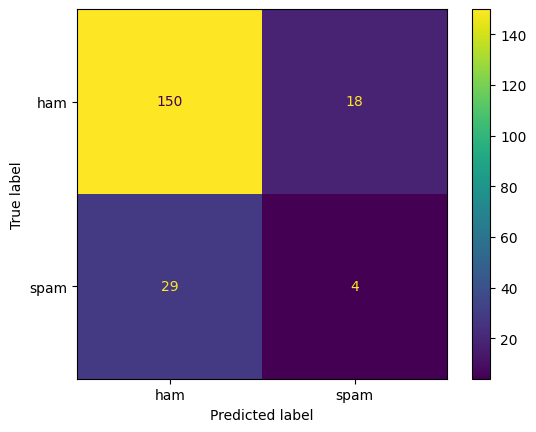


K Means scores:
Mean Squared Error		0.592
Mean Absolute Error		0.592
False Positive Rate		0.836
False Negative Rate		0.071
Accuracy			0.408
Precision			0.164
Recall				0.636
F1				0.261


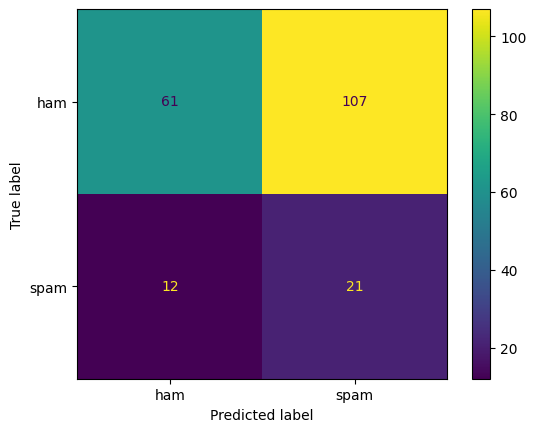


K Nearest Neighbor scores:
Mean Squared Error		0.234
Mean Absolute Error		0.234
False Positive Rate		0.818
False Negative Rate		0.173
Accuracy			0.766
Precision			0.182
Recall				0.121
F1				0.145


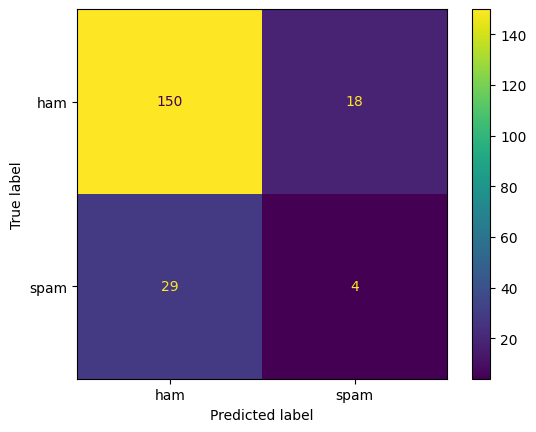


Linear Regression scores:
Mean Squared Error		0.204
Mean Absolute Error		0.204
False Positive Rate		0.833
False Negative Rate		0.185
Accuracy			0.796
Precision			0.167
Recall				0.061
F1				0.089


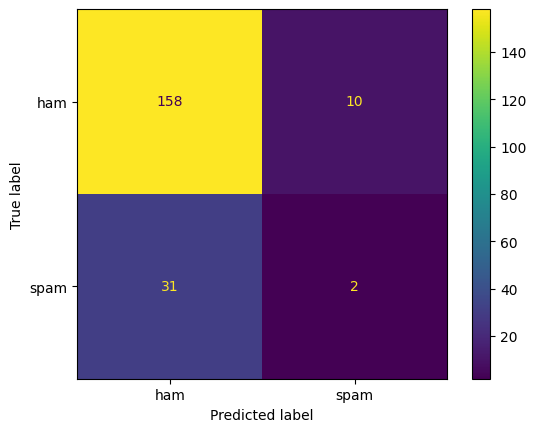


Multi-Layer Perceptron scores:
Mean Squared Error		0.234
Mean Absolute Error		0.234
False Positive Rate		0.818
False Negative Rate		0.173
Accuracy			0.766
Precision			0.182
Recall				0.121
F1				0.145


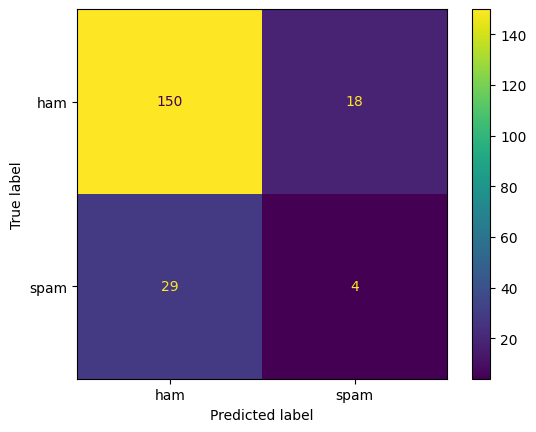


Naive Bayes scores:
Mean Squared Error		0.234
Mean Absolute Error		0.234
False Positive Rate		0.818
False Negative Rate		0.173
Accuracy			0.766
Precision			0.182
Recall				0.121
F1				0.145


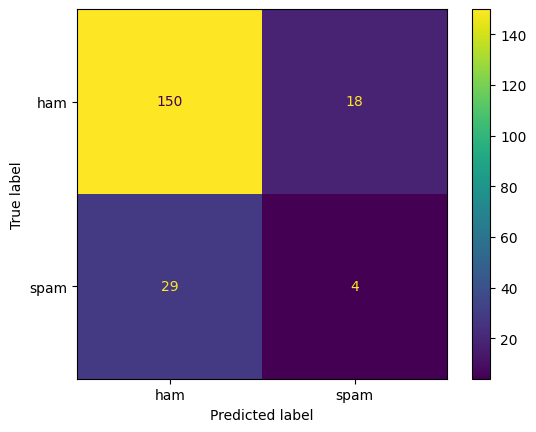


Random Forest scores:
Mean Squared Error		0.234
Mean Absolute Error		0.234
False Positive Rate		0.818
False Negative Rate		0.173
Accuracy			0.766
Precision			0.182
Recall				0.121
F1				0.145


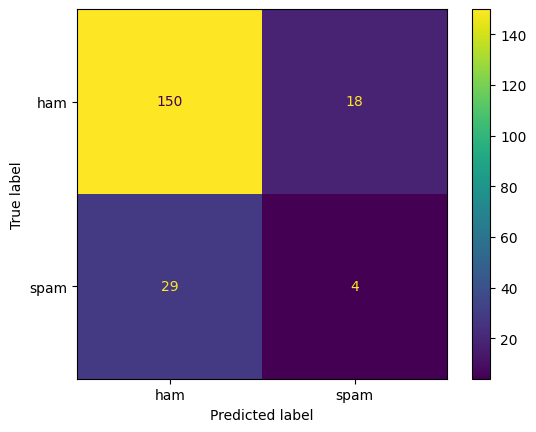


Spectral Clustering scores:
Mean Squared Error		0.164
Mean Absolute Error		0.164
False Positive Rate		0.500
False Negative Rate		0.185
Accuracy			0.836
Precision			0.500
Recall				0.061
F1				0.108


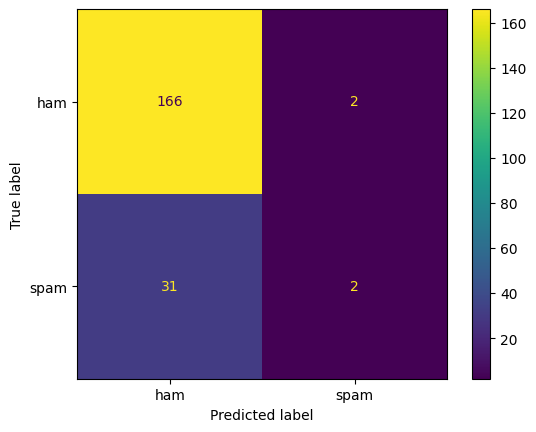


Support Vector scores:
Mean Squared Error		0.234
Mean Absolute Error		0.234
False Positive Rate		0.818
False Negative Rate		0.173
Accuracy			0.766
Precision			0.182
Recall				0.121
F1				0.145


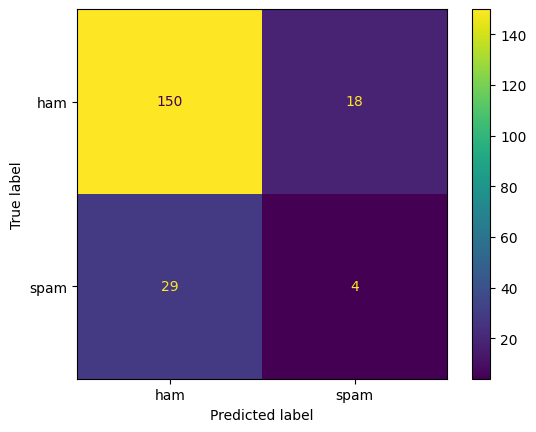


baseline scores:
Mean Squared Error		0.164
Mean Absolute Error		0.164
False Positive Rate		nan
False Negative Rate		0.196
Accuracy			0.836
Precision			0.000
Recall				0.000
F1				0.000


<ipython-input-92-5e017bf48ca1>:14: RuntimeWarning: invalid value encountered in scalar divide
  "False Positive Rate\t": confusion[0][1]/confusion.sum(axis=0)[1],


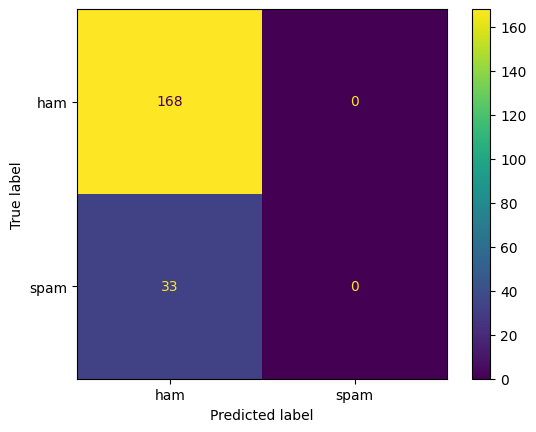

In [92]:
# get scoring metrics
scores = {}
scores_df = pd.DataFrame()
model_names = sorted(list(set(expected_and_predictions.columns) - {"actual"}))

for model_name in model_names:

    confusion = confusion_matrix(expected_and_predictions["actual"], expected_and_predictions[model_name])


    scores[model_name] = {
        "Mean Squared Error\t": mean_squared_error(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Mean Absolute Error\t":  mean_absolute_error(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "False Positive Rate\t": confusion[0][1]/confusion.sum(axis=0)[1],
        "False Negative Rate\t": confusion[1][0]/confusion.sum(axis=1)[0],
        "Accuracy\t\t": accuracy_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Precision\t\t": precision_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Recall\t\t\t":  recall_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "F1\t\t\t":  f1_score(expected_and_predictions["actual"], expected_and_predictions[model_name])
    }

    print(model_name + " scores:")

    for metric, value in scores[model_name].items():
        print(metric + format(value))

    confusion_display = ConfusionMatrixDisplay(confusion, display_labels=["ham", "spam"])
    confusion_display.plot()
    plt.show()

    print()

In [93]:
mislabelled_sms = expected_and_predictions[model_names]
mislabelled_sms["mean pred class"] = mislabelled_sms.mean(axis=1)

mislabelled_cols = list(mislabelled_sms.columns)
col_names = list(mislabelled_sms.columns) + ["class", "text"]

# merge the df's
mislabelled_sms = pd.concat([mislabelled_sms, test], axis=1, ignore_index=True)

# rename the columns
mislabelled_sms.columns = list(mislabelled_cols) + list(test.columns)

# drop unnecessary cols
mislabelled_sms = mislabelled_sms[col_names]

In [94]:
mislabelled_sms = mislabelled_sms[abs(mislabelled_sms["class"] - mislabelled_sms["mean pred class"]) > 0.5]
mislabelled_sms

,Decision Tree,K Means,K Nearest Neighbor,Linear Regression,Multi-Layer Perceptron,Naive Bayes,Random Forest,Spectral Clustering,Support Vector,baseline,mean pred class,class,text
19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1,"Thanks for your Ringtone Order, Reference T91...."
39,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.7,0,Yun ah.the ubi one say if ü wan call by tomorr...
48,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1,Email AlertFrom: Jeri StewartSize: 2KBSubject:...
74,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1,Reminder: You have not downloaded the content ...
83,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1,You'll not rcv any more msgs from the chat svc...
98,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1,SMS. ac Blind Date 4U!: Rodds1 is 21/m from Ab...
161,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1,Talk sexy!! Make new friends or fall in love i...
180,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1,You have an important customer service announc...


##Cross-Validation

In [70]:
def get_spam_cv_scores(X, y, cv=5, metric="f1"):

    scores = pd.DataFrame({
        "Decision Tree": cross_val_score(dt, X, y, cv=cv, scoring=metric),
        "K Means": cross_val_score(km, X, y, cv=cv, scoring=metric),
        "K Nearest Neighbor": cross_val_score(knn, X, y, cv=cv, scoring=metric),
        "Linear Regression": cross_val_score(lr, X, y, cv=cv, scoring=metric),
        "Multi-Layer Perceptron": cross_val_score(mlp, X, y, cv=cv, scoring=metric),
        "Naive Bayes": cross_val_score(nb, X, y, cv=cv, scoring=metric),
        "Spectral Clustering": cross_val_score(spectral, X, y, cv=cv, scoring=metric),
        "Support Vector": cross_val_score(svc, X, y, cv=cv, scoring=metric),
        "Random Forest": cross_val_score(rf, X, y, cv=cv, scoring=metric) #,
        # "Voting Classifier": cross_val_score(get_voting_classifier(), X, y, cv=cv, scoring=metric)
    })

    return scores

In [75]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [77]:
cv_acc_scores = get_spam_cv_scores(all_corpus_embeddings_dense, corpus["class"], 5, "accuracy")
cv_acc_scores.head()

,Decision Tree,K Means,K Nearest Neighbor,Linear Regression,Multi-Layer Perceptron,Naive Bayes,Spectral Clustering,Support Vector,Random Forest
0,0.955224,0.39801,NaN,NaN,NaN,0.985075,NaN,0.975124,0.970149
1,0.960000,0.61000,NaN,NaN,NaN,0.985000,NaN,0.985000,0.980000
2,0.965000,0.39000,NaN,NaN,NaN,0.985000,NaN,0.995000,0.990000
3,0.960000,0.44000,NaN,NaN,NaN,0.980000,NaN,0.985000,0.975000
4,0.970000,0.55500,NaN,NaN,NaN,0.970000,NaN,0.980000,0.975000


In [72]:
cv_f1_scores = get_spam_cv_scores(all_corpus_embeddings_dense, corpus["class"], 5, "f1")
cv_f1_scores.head()

,Decision Tree,K Means,K Nearest Neighbor,Linear Regression,Multi-Layer Perceptron,Naive Bayes,Spectral Clustering,Support Vector,Random Forest
0,0.840580,0.016260,NaN,NaN,NaN,0.950820,NaN,0.912281,0.931034
1,0.888889,0.400000,NaN,NaN,NaN,0.950820,NaN,0.947368,0.912281
2,0.888889,0.016129,NaN,NaN,NaN,0.949153,NaN,0.983051,0.965517
3,0.872727,0.017544,NaN,NaN,NaN,0.933333,NaN,0.947368,0.912281
4,0.898551,0.425806,NaN,NaN,NaN,0.903226,NaN,0.933333,0.949153
